In [1]:
# Import Libraries
from ta import add_all_ta_features
import pandas as pd
import requests
import io
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import json
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import model_from_json
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Import main price dataset from Github

# Downloading the csv file from your GitHub account
url = "https://raw.githubusercontent.com/Yu821/stock_price_prediction/main/data/price.csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe
financial = pd.read_csv(io.StringIO(download.decode('utf-8')))

financial.iloc[:,0:20].head()


,change,changeOverTime,changePercent,close,fClose,fHigh,fLow,fOpen,fVolume,high,id,key,label,low,marketChangeOverTime,open,subkey,symbol,uClose,uHigh
0,0.00,0.000000,0.0000,123.00,123.00,124.1800,122.4900,123.66,75089134,124.1800,HISTORICAL_PRICES,AAPL,"Apr 1, 21",122.4900,0.000000,123.66,NaN,AAPL,123.00,124.1800
1,-0.85,-0.006911,-0.0069,122.15,122.15,123.5200,121.1500,121.65,118323826,123.5200,HISTORICAL_PRICES,AAPL,"Mar 31, 21",121.1500,-0.006911,121.65,NaN,AAPL,122.15,123.5200
2,-2.25,-0.025203,-0.0184,119.90,119.90,120.4031,118.8600,120.11,85671919,120.4031,HISTORICAL_PRICES,AAPL,"Mar 30, 21",118.8600,-0.025203,120.11,NaN,AAPL,119.90,120.4031
3,1.49,-0.013089,0.0124,121.39,121.39,122.5800,120.7299,121.65,80819203,122.5800,HISTORICAL_PRICES,AAPL,"Mar 29, 21",120.7299,-0.013089,121.65,NaN,AAPL,121.39,122.5800
4,-0.18,-0.014553,-0.0015,121.21,121.21,121.4800,118.9200,120.35,94071234,121.4800,HISTORICAL_PRICES,AAPL,"Mar 26, 21",118.9200,-0.014553,120.35,NaN,AAPL,121.21,121.4800


In [3]:

financial.loc[:, 'date'] = pd.DatetimeIndex(financial['label'])

financial.loc[:, 'date'] = financial['date'].dt.strftime('%Y-%m-%d')

finance = financial[['change', 'changeOverTime', 'changePercent', 'close', 'high', 'low',
       'marketChangeOverTime', 'open', 'symbol',
       'volume', 'date']]

finance.date = pd.DatetimeIndex(finance['date'])

finance.date = finance['date'].dt.strftime('%Y-%m-%d')

finance.head()

,change,changeOverTime,changePercent,close,high,low,marketChangeOverTime,open,symbol,volume,date
0,0.00,0.000000,0.0000,123.00,124.1800,122.4900,0.000000,123.66,AAPL,75089134,2021-04-01
1,-0.85,-0.006911,-0.0069,122.15,123.5200,121.1500,-0.006911,121.65,AAPL,118323826,2021-03-31
2,-2.25,-0.025203,-0.0184,119.90,120.4031,118.8600,-0.025203,120.11,AAPL,85671919,2021-03-30
3,1.49,-0.013089,0.0124,121.39,122.5800,120.7299,-0.013089,121.65,AAPL,80819203,2021-03-29
4,-0.18,-0.014553,-0.0015,121.21,121.4800,118.9200,-0.014553,120.35,AAPL,94071234,2021-03-26


In [4]:
# Import stock news dataset from Github

# Downloading the csv file from your GitHub account
url = "https://raw.githubusercontent.com/Yu821/stock_price_prediction/main/data/stock_news_data.csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe
stock_news = pd.read_csv(io.StringIO(download.decode('utf-8')))

stock_news = stock_news.groupby('date').agg({'score' : 'mean'}).reset_index()

# Import market news dataset from Github

# Downloading the csv file from your GitHub account
url = "https://raw.githubusercontent.com/Yu821/stock_price_prediction/main/data/market_news_data.csv"
download = requests.get(url).content

# Reading the downloaded content and turning it into a pandas dataframe
market_news = pd.read_csv(io.StringIO(download.decode('utf-8')))

market_news = market_news.groupby('date').agg({'score' : 'mean'}).reset_index()

news_scores = stock_news.merge(market_news, on = 'date')

news_scores.columns = ["date", "stock_news_score", "market_news_score"]

print(news_scores.shape)
news_scores.head()


(560, 3)


,date,stock_news_score,market_news_score
0,2019-04-02,-0.140500,-0.458800
1,2019-04-03,0.190633,-0.431067
2,2019-04-04,-0.004880,0.014725
3,2019-04-06,0.120400,0.177900
4,2019-04-08,0.251600,0.102700


In [5]:
finance = finance.merge(news_scores, on = 'date', how = 'left')
finance = finance.fillna(0)
finance.tail()

,change,changeOverTime,changePercent,close,high,low,marketChangeOverTime,open,symbol,volume,date,stock_news_score,market_news_score
12583,0.11,-0.775449,0.0020,54.42,55.28,54.32,-0.775449,54.67,MSFT,22167223,2016-04-08,0.0,0.0
12584,0.04,-0.775284,0.0007,54.46,54.91,54.23,-0.775284,54.87,MSFT,19225092,2016-04-07,0.0,0.0
12585,0.66,-0.772560,0.0121,55.12,55.20,54.21,-0.772560,54.36,MSFT,21188682,2016-04-06,0.0,0.0
12586,-0.56,-0.774871,-0.0102,54.56,55.30,54.46,-0.774871,55.19,MSFT,19272255,2016-04-05,0.0,0.0
12587,0.87,-0.771281,0.0159,55.43,55.66,55.00,-0.771281,55.43,MSFT,18928810,2016-04-04,0.0,0.0


# LSTM

In [6]:
def calculate_accuracy(X_test, y_test, regressor, DataScaler_Y):
    
    y_pred = np.mean(DataScaler_Y.inverse_transform(regressor.predict(X_test)), axis = 1)
    Y_Test = np.mean(DataScaler_Y.inverse_transform(y_test), axis = 1)
    
    mae = mean_absolute_error(Y_Test, y_pred)
    mse = mean_squared_error(Y_Test, y_pred)
    
    scores = []
    percents = [1, 2, 3]
    total = len(Y_Test)

    for percent in percents:
        
        correct = 0
        
        for i in range(len(Y_Test)):
            upper = Y_Test[i] + (( percent / 100) * Y_Test[i] )
            lower = Y_Test[i] - (( percent / 100) * Y_Test[i] )
            if y_pred[i] < upper and y_pred[i] > lower:
                correct = correct + 1
            else:
                pass

        score = (correct/total)*100
        scores.append(score)
    
    return scores, mae, mse

def prepare_stock_data(stock):
    
    data_sym = finance[finance['symbol'] == stock]

    data_sym = create_technical(data_sym)

    drop = ['symbol', 'date']

    data_sym = data_sym.drop(drop, axis = 1)

    y_sym = data_sym[['open']]

    X_sym = data_sym.drop(['open'], axis = 1)

    X_sym, y_sym, DataScaler_Y = normalize(X_sym, y_sym)
    
    return X_sym, y_sym, DataScaler_Y


def create_technical(dataset):
    
    dataset.loc[:,:] = add_all_ta_features(dataset.copy(), open="open", high="high", low="low", close="close",
                                         volume="volume", fillna=True)
    
    dataset.loc[:,:] = dataset.sort_values(by='date')
    
    # Create 7 and 21 days Moving Average
    dataset.loc[:, 'ma7'] = dataset.loc[:, 'open'].rolling(window=7).mean()
    dataset.loc[:, 'ma21'] = dataset.loc[:, 'open'].rolling(window=21).mean()
    
    # Create MACD
    dataset.loc[:, '26ema'] = dataset.loc[:, 'open'].ewm(span=26).mean()
    dataset.loc[:, '12ema'] = dataset.loc[:, 'open'].ewm(span=12).mean()
    dataset.loc[:, 'MACD'] = (dataset.loc[:, '12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset.loc[:, '20sd'] = dataset.loc[:, 'open'].rolling(window = 20).std()
    dataset.loc[:, 'upper_band'] = dataset.loc[:, 'ma21'] + (dataset.loc[:, '20sd']*2)
    dataset.loc[:, 'lower_band'] = dataset.loc[:, 'ma21'] - (dataset.loc[:, '20sd']*2)
    
    # Create Exponential moving average
    dataset.loc[:, 'ema'] = dataset.loc[:, 'open'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset.loc[:, 'momentum'] = dataset.loc[:, 'open']-1
    
    # Stochastic Oscillator
    close = dataset.loc[:, 'close']
    highest_hi = dataset.loc[:, 'high'].rolling(window = 10).max()
    lowest_lo = dataset.loc[:, 'low'].rolling(window = 10).min()
    
    dataset.loc[:, 'per_k_stock_10'] = (close - lowest_lo) / (highest_hi - lowest_lo) * 100
    dataset.loc[:, 'per_d_stock_10'] = dataset.loc[:, 'per_k_stock_10'].rolling(window = 10).mean()
    
    dataset = dataset.fillna(0)
    
    return dataset


def normalize(X, Y):

    sc = MinMaxScaler()

    DataScaler_X = sc.fit(X)
    transformed_X = DataScaler_X.transform(X)
    X = pd.DataFrame(transformed_X, columns = X.columns)

    DataScaler_Y = sc.fit(Y)
    transformed_Y = DataScaler_Y.transform(Y)
    Y = pd.DataFrame(transformed_Y, columns = Y.columns)

    return X.to_numpy(), Y.to_numpy(), DataScaler_Y


def reshape_data_1(X, Y):
    # split into samples
    X_samples = list()
    y_samples = list()

    NumerOfRows = X.shape[0]

    TimeSteps = 5 # next day's Price Prediction is based on last how many past day's prices
    FutureTimeSteps = 1 # How many days in future you want to predict the prices

    # Iterate thru the values to create combinations
    for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
        x_sample = X[i-TimeSteps:i]
        y_sample = Y[i:i+FutureTimeSteps]
        X_samples.append(x_sample)
        y_samples.append(y_sample)

    # Reshape the Input as a 3D (number of samples, Time Steps, Features)
    X_data = np.array(X_samples)
    X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], X.shape[1])

    # We do not reshape y as a 3D data  as it is supposed to be a single column only
    y_data = np.array(y_samples)
    y_data = y_data.reshape(y_data.shape[0], FutureTimeSteps)
    
    return X_data, y_data


def reshape_data_5(X, Y):
    # split into samples
    X_samples = list()
    y_samples = list()

    NumerOfRows = X.shape[0]

    TimeSteps = 12 # next day's Price Prediction is based on last how many past day's prices
    FutureTimeSteps = 5 # How many days in future you want to predict the prices

    # Iterate thru the values to create combinations
    for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
        x_sample = X[i-TimeSteps:i]
        y_sample = Y[i:i+FutureTimeSteps]
        X_samples.append(x_sample)
        y_samples.append(y_sample)

    # Reshape the Input as a 3D (number of samples, Time Steps, Features)
    X_data = np.array(X_samples)
    X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], X.shape[1])

    # We do not reshape y as a 3D data  as it is supposed to be a single column only
    y_data = np.array(y_samples)
    y_data = y_data.reshape(y_data.shape[0], FutureTimeSteps)
    
    return X_data, y_data



In [7]:

def compare_time_splits(stock, days):
    # Collects the percentage accuracies and MAE for each time-series split for the specific stock and amount
    # of days in the future we are trying to predict
    
    # Split data into four segments
    tscv = TimeSeriesSplit(n_splits = 4)
    
    # Prepare data for the specific stock
    X_sym, y_sym, DataScaler_Y = prepare_stock_data(stock)
    
    time = 1
    
    # Collect the percentage accuracies and MAE for each split
    scores = []
    
    for tr_index, val_index in tscv.split(X_sym):
        
        X_tr, X_val = X_sym[tr_index], X_sym[val_index]
        y_tr, y_val = y_sym[tr_index], y_sym[val_index]
        
        # Reshape data depending on how many days in the future we are trying to predict
        if days == "One":
            X_tr, y_tr = reshape_data_1(X_tr, y_tr)
            X_val, y_val = reshape_data_1(X_val, y_val)
        
        else:
            X_tr, y_tr = reshape_data_5(X_tr, y_tr)
            X_val, y_val = reshape_data_5(X_val, y_val)
        
        # load json and create model

        # Downloading the json file from your GitHub account
        url = "https://raw.githubusercontent.com/Yu821/stock_price_prediction/main/models/saved/{}_{}_{}.json".format(days, stock, time)
        download = json.loads(requests.get(url).text)
        model = model_from_json(json.dumps(download))
        
        # Downloading the h5 file from your GitHub account
        url = "https://raw.githubusercontent.com/Yu821/stock_price_prediction/main/models/saved/{}_{}_{}.h5".format(days, stock, time)
        download = requests.get(url, allow_redirects=True)
        open('weights', 'wb').write(download.content)
        # load weights into new model
        model.load_weights('weights')

        # evaluate loaded model on test data
        model.compile(loss='mean_squared_error', optimizer='Adam')
        
        accuracy, mae, mse = calculate_accuracy(X_val, y_val, model, DataScaler_Y)
        score = model.evaluate(X_val, y_val, verbose = 0) 
        
        combined = (accuracy, score, mae, mse)
        scores.append(combined)
        
        time = time + 1
    
    return scores
    

## Facebook

### One-day ahead prediction

In [13]:
# Get percentage accuracies and MAE of all the models for Apple stock for both ONE day predictions

symbol = "FB"
    
score_one = compare_time_splits(symbol, "One")

print("For One Day Predictions")
print("=======================")

print("Time Split One")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(score_one[0][0][0]))
print("{}% of predictions were 2% away from actual price".format(score_one[0][0][1]))
print("{}% of predictions were 3% away from actual price".format(score_one[0][0][2]))
print("MAE = {}".format(score_one[0][2]))
print("MSE = {}".format(score_one[0][3]))
print("=======================")

print("Time Split Two")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(score_one[1][0][0]))
print("{}% of predictions were 2% away from actual price".format(score_one[1][0][1]))
print("{}% of predictions were 3% away from actual price".format(score_one[1][0][2]))
print("MAE = {}".format(score_one[1][2]))
print("MSE = {}".format(score_one[1][3]))
print("=======================")

print("Time Split Three")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(score_one[2][0][0]))
print("{}% of predictions were 2% away from actual price".format(score_one[2][0][1]))
print("{}% of predictions were 3% away from actual price".format(score_one[2][0][2]))
print("MAE = {}".format(score_one[2][2]))
print("MSE = {}".format(score_one[2][3]))
print("=======================")

print("Time Split Four")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(score_one[3][0][0]))
print("{}% of predictions were 2% away from actual price".format(score_one[3][0][1]))
print("{}% of predictions were 3% away from actual price".format(score_one[3][0][2]))
print("MAE = {}".format(score_one[3][2]))
print("MSE = {}".format(score_one[3][3]))
print("=======================")

one_away = (score_one[0][0][0] + score_one[1][0][0] + score_one[2][0][0] + score_one[3][0][0]) / 4
two_away = (score_one[0][0][1] + score_one[1][0][1] + score_one[2][0][1] + score_one[3][0][1]) / 4
three_away = (score_one[0][0][2] + score_one[1][0][2] + score_one[2][0][2] + score_one[3][0][2]) / 4
MAE_avg = ((score_one[0][2] + score_one[1][2] + score_one[2][2] + score_one[3][2]) / 4)
MSE_avg = ((score_one[0][3] + score_one[1][3] + score_one[2][3] + score_one[3][3]) / 4) 

print("Averages")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(one_away))
print("{}% of predictions were 2% away from actual price".format(two_away))
print("{}% of predictions were 3% away from actual price".format(three_away))
print("MAE = {}".format(MAE_avg))
print("MSE = {}".format(MSE_avg))
print("=======================")


For One Day Predictions
Time Split One
34.69387755102041% of predictions were 1% away from actual price
63.6734693877551% of predictions were 2% away from actual price
79.59183673469387% of predictions were 3% away from actual price
MAE = 3.6875571420599482
MSE = 24.402532585833043
Time Split Two
28.97959183673469% of predictions were 1% away from actual price
55.10204081632652% of predictions were 2% away from actual price
68.9795918367347% of predictions were 3% away from actual price
MAE = 4.072441523038903
MSE = 34.96937075017232
Time Split Three
43.673469387755105% of predictions were 1% away from actual price
77.14285714285715% of predictions were 2% away from actual price
93.06122448979592% of predictions were 3% away from actual price
MAE = 2.274186099928252
MSE = 8.183544574015068
Time Split Four
42.857142857142854% of predictions were 1% away from actual price
74.28571428571429% of predictions were 2% away from actual price
89.38775510204081% of predictions were 3% away from 

### Five-days ahead prediction

In [12]:
# Get percentage accuracies and MAE of all the models for Apple stock for both FIVE day predictions

symbol = "AAPL"
    
score_five = compare_time_splits(symbol, "Five")

print("For Five Day Predictions")
print("=======================")

print("Time Split One")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(score_five[0][0][0]))
print("{}% of predictions were 2% away from actual price".format(score_five[0][0][1]))
print("{}% of predictions were 3% away from actual price".format(score_five[0][0][2]))
print("MAE = {}".format(score_five[0][2]))
print("MSE = {}".format(score_five[0][3]))
print("=======================")

print("Time Split Two")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(score_five[1][0][0]))
print("{}% of predictions were 2% away from actual price".format(score_five[1][0][1]))
print("{}% of predictions were 3% away from actual price".format(score_five[1][0][2]))
print("MAE = {}".format(score_five[1][2]))
print("MSE = {}".format(score_five[1][3]))
print("=======================")

print("Time Split Three")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(score_five[2][0][0]))
print("{}% of predictions were 2% away from actual price".format(score_five[2][0][1]))
print("{}% of predictions were 3% away from actual price".format(score_five[2][0][2]))
print("MAE = {}".format(score_five[2][2]))
print("MSE = {}".format(score_five[2][3]))
print("=======================")

print("Time Split Four")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(score_five[3][0][0]))
print("{}% of predictions were 2% away from actual price".format(score_five[3][0][1]))
print("{}% of predictions were 3% away from actual price".format(score_five[3][0][2]))
print("MAE = {}".format(score_five[3][2]))
print("MSE = {}".format(score_five[3][3]))
print("=======================")

one_away = (score_five[0][0][0] + score_five[1][0][0] + score_five[2][0][0] + score_five[3][0][0]) / 4
two_away = (score_five[0][0][1] + score_five[1][0][1] + score_five[2][0][1] + score_five[3][0][1]) / 4
three_away = (score_five[0][0][2] + score_five[1][0][2] + score_five[2][0][2] + score_five[3][0][2]) / 4
MAE_avg = ((score_five[0][2] + score_five[1][2] + score_five[2][2] + score_five[3][2]) / 4) 
MSE_avg = ((score_five[0][3] + score_five[1][3] + score_five[2][3] + score_five[3][3]) / 4) 

print("Averages")
print("=======================")
print("{}% of predictions were 1% away from actual price".format(one_away))
print("{}% of predictions were 2% away from actual price".format(two_away))
print("{}% of predictions were 3% away from actual price".format(three_away))
print("MAE = {}".format(MAE_avg))
print("MSE = {}".format(MSE_avg))
print("=======================")


For Five Day Predictions
Time Split One
8.11965811965812% of predictions were 1% away from actual price
27.350427350427353% of predictions were 2% away from actual price
36.75213675213676% of predictions were 3% away from actual price
MAE = 2.871130297877646
MSE = 12.983009304180932
Time Split Two
21.367521367521366% of predictions were 1% away from actual price
44.01709401709402% of predictions were 2% away from actual price
63.67521367521367% of predictions were 3% away from actual price
MAE = 1.2151092745528265
MSE = 2.1797503596567096
Time Split Three
31.62393162393162% of predictions were 1% away from actual price
56.837606837606835% of predictions were 2% away from actual price
71.36752136752136% of predictions were 3% away from actual price
MAE = 0.8347292406548399
MSE = 1.0873828960167848
Time Split Four
8.974358974358974% of predictions were 1% away from actual price
23.504273504273502% of predictions were 2% away from actual price
37.17948717948718% of predictions were 3% awa

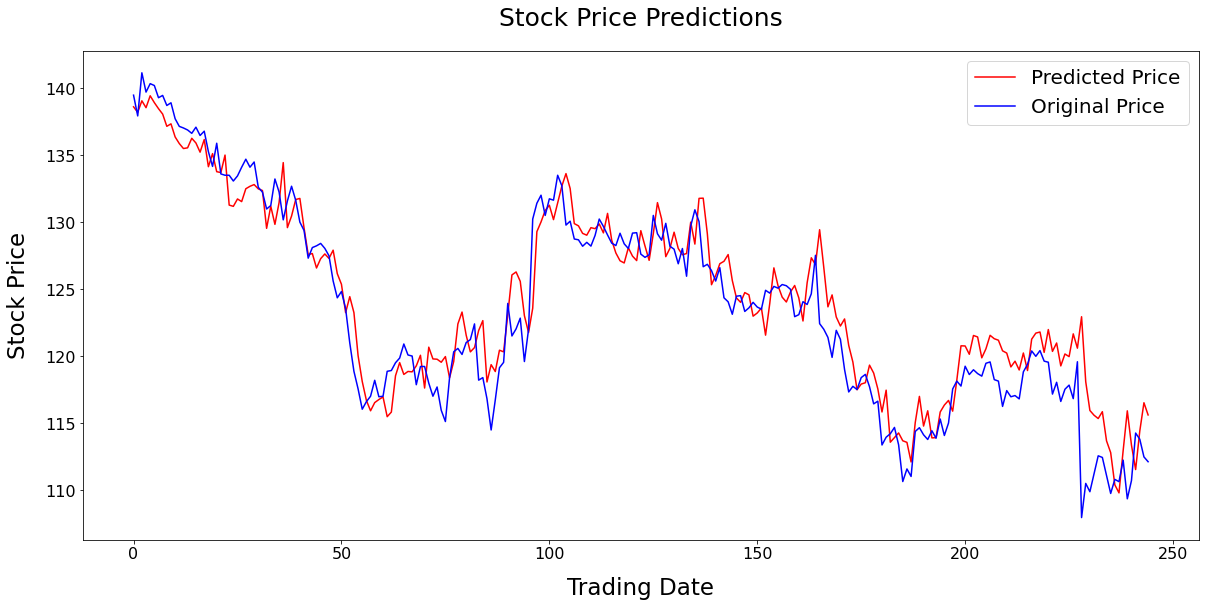

In [14]:
# Example Plot of Predictions VS. Actual for APPL Stock

stock = "FB"
days = "One"
tscv = TimeSeriesSplit(n_splits = 4)

X_sym, y_sym, DataScaler_Y = prepare_stock_data(stock)
time = 1
scores = []

for tr_index, val_index in tscv.split(X_sym):
    
    if time <= 3:
        pass
    
    X_tr, X_val = X_sym[tr_index], X_sym[val_index]
    y_tr, y_val = y_sym[tr_index], y_sym[val_index]

    
    X_tr, y_tr = reshape_data_1(X_tr, y_tr)
    X_val, y_val = reshape_data_1(X_val, y_val)

    # load json and create model

    # Downloading the json file from your GitHub account
    url = "https://raw.githubusercontent.com/Yu821/stock_price_prediction/main/models/saved/{}_{}_{}.json".format(days, stock, time)
    download = json.loads(requests.get(url).text)
    model = model_from_json(json.dumps(download))

    # Downloading the h5 file from your GitHub account
    url = "https://raw.githubusercontent.com/Yu821/stock_price_prediction/main/models/saved/{}_{}_{}.h5".format(days, stock, time)
    download = requests.get(url, allow_redirects=True)
    open('weights', 'wb').write(download.content)
    # load weights into new model
    model.load_weights('weights')

    # evaluate loaded model on test data
    model.compile(loss='mean_squared_error', optimizer='Adam')

    time = time + 1
    
# Generating predictions on last time-series split
TestPredictions = DataScaler_Y.inverse_transform(model.predict(X_val))
Y_Test = DataScaler_Y.inverse_transform(y_val)

# plotting both the predictions and original data
plt.plot(TestPredictions, color = 'red', label = 'Predicted Price')
plt.plot(Y_Test , color = 'blue', label = 'Original Price')

plt.title('Stock Price Predictions', size = 25, pad = 25)
plt.xlabel('Trading Date', size = 23, labelpad = 15)
plt.ylabel('Stock Price', size = 23, labelpad = 15)

plt.legend(prop = {'size': 20})

plt.xticks(size = 16)
plt.yticks(size = 16)

fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(9)
plt.show()


We can see that predicted price pretty much follows the original price although it quite doesn't follow at the start of COVID-19. This implies that the model is generalized, but can't capture the sudden spikes caused by some events such as COVID-19.

Also, LSTM model is not affected by the target much (either 1-day or 5-days) meaning that LSTM is stable model.

# LightGBM

## 1-day ahead prediction

In [11]:
import pickle
import lightgbm as lgb

In [12]:
  
train_X = pickle.load(open(f"./models/saved/tree_train_X.pkl", "rb"))
train_y = pickle.load(open(f"./models/saved/tree_train_y_1day.pkl", "rb"))

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from statistics import mean
import pickle
import lightgbm as lgb


def output_lgb_model(train_X, train_y):
    metric = 'l1'


    # Hyperparameters are tuned already
    params = {
              'objective': 'regression_l1',
              'num_leaves': 30,
              'min_data_in_leaf': 20,
              'max_depth': -1,
              'learning_rate': 0.01,
             }




    oof = np.zeros(len(train_X))
    feature_importance_df = pd.DataFrame()

    percentage_lst = {k: [] for k in range(1, 4)}

    # Put mae of targets and the mean of targets. This becomes the criteria or standard of
    # judging whether the model performance is good.
    standard = {"mae": [] , "mse": []}

    acc = {"mae": [] , "mse": []}
    folds = TimeSeriesSplit(n_splits=4)


    print('train_X: ',train_X.shape)
    print('train_y: ',train_y.shape)

    #run model
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X, train_y)):
        strLog = "\n fold {}".format(fold_)
        print(strLog)

        # Output the size of train and validation set
        print('train_idx: ',len(trn_idx))
        print('val_idx: ',len(val_idx))

        X_tr, X_val = train_X.iloc[trn_idx], train_X.iloc[val_idx]
        y_tr, y_val = train_y.iloc[trn_idx], train_y.iloc[val_idx]


    # 		model = lgb.LGBMRegressor(**params, n_estimators=10000, importance_type='gain', n_jobs=-1)

    # 		model.fit(X_tr,
    # 				  y_tr,
    # 				  eval_set=[(X_tr,y_tr),(X_val, y_val)],
    # 				  verbose=1000,
    # 				  early_stopping_rounds=200
    # 				  )
    #         Load model
        model = pickle.load(open(f"./models/saved/model_{fold_}.pkl", "rb"))


        preds = model.predict(X_val, num_iteration=model.best_iteration_)
        oof[val_idx] += preds

        print()
        print("MAE: ", model.best_score_['valid_1'][metric])
        print("MSE: ", mean_squared_error(preds, y_val), "\n")

        acc["mae"].append(model.best_score_['valid_1'][metric])
        acc["mse"].append(mean_squared_error(preds, y_val))


    # 		print(oof[val_idx])
        medians = np.repeat(np.median(y_val), y_val.shape[0])
        print("Target - median(target): ", mean_absolute_error(medians, y_val))

        means = np.repeat(np.mean(y_val), y_val.shape[0])
        print("Target - mean(target): ", mean_absolute_error(means, y_val), "\n")

        standard["mae"].append(mean_absolute_error(means, y_val))
        standard["mse"].append(mean_squared_error(means, y_val))


        percentages = [1,2,3]
        total = len(y_val.values)

        y_val.reset_index(drop=True, inplace=True)
        y_val = y_val.values


        for percent in percentages:
            correct = 0

            for i in range(len(y_val)):
                upper = y_val[i] + (( percent / 100) * y_val[i] )
                lower = y_val[i] - (( percent / 100) * y_val[i] )
                if preds[i] < upper and preds[i] > lower:
                    correct = correct + 1
                else:
                    pass

            print("{}% of the predictions were {}% away from actual price".format(round((correct/total)*100,2), percent))

            percentage_lst[percent].append(round((correct/total)*100,2))

        print("\n")

        acc["mae"].append(model.best_score_['valid_1'][metric])

        #feature importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = train_X.columns.values
        fold_importance_df["importance"] = model.feature_importances_[:len(train_X.columns.values)]
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


    print("Mean validation MAE: ", mean(acc["mae"]))
    print("MAE when we setted all predictions to be the mean of target: ", mean(standard["mae"]), "\n")

    print("Mean validation MSE: ", mean(acc["mse"]))
    print("MSE when we setted all predictions to be the mean of target: ", mean(standard["mse"]), "\n")

    print()

    for key in percentage_lst.keys():
        print(mean(percentage_lst[key]),  f"% of the predictions were {key}% away from actual price in average (all folds)")

    return feature_importance_df


In [19]:
feature_importance_df = output_lgb_model(train_X, train_y)

train_X:  (12538, 116)
train_y:  (12538,)

 fold 0
train_idx:  2510
val_idx:  2507

MAE:  9.226826538167717
MSE:  361.25515637244814 

Target - median(target):  47.87826134822497
Target - mean(target):  49.92368739667741 

30.08% of the predictions were 1% away from actual price
46.19% of the predictions were 2% away from actual price
58.56% of the predictions were 3% away from actual price



 fold 1
train_idx:  5017
val_idx:  2507

MAE:  4.663635212465788
MSE:  120.75356735998695 

Target - median(target):  58.75951751096929
Target - mean(target):  60.07687553961795 

45.59% of the predictions were 1% away from actual price
60.07% of the predictions were 2% away from actual price
68.05% of the predictions were 3% away from actual price



 fold 2
train_idx:  7524
val_idx:  2507

MAE:  13.580866396634816
MSE:  1449.125783896358 

Target - median(target):  83.5409103709613
Target - mean(target):  85.89433639664551 

54.17% of the predictions were 1% away from actual price
69.88% of the

To see if we have satisfactory results, we compared our MAE with one when we set all predictions to be the mean of the target described in "MAE when we setted all predictions to be the mean of target:".

We can see that our model is predicting the target well because the error for model predictions are much lower than those of“MAE when we setted all predictions to be the mean of target.


However, MSE is not so good. This may be because the models are able to predict general change in price well; however, it may not predict outliers caused by some unexpected events such as COVID-19.

We also see that MAE for 2020 and 2021 is much worse. This may be because of COVID-19.

Text(0.5, 1.0, 'Features importance (averaged/folds) ')

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


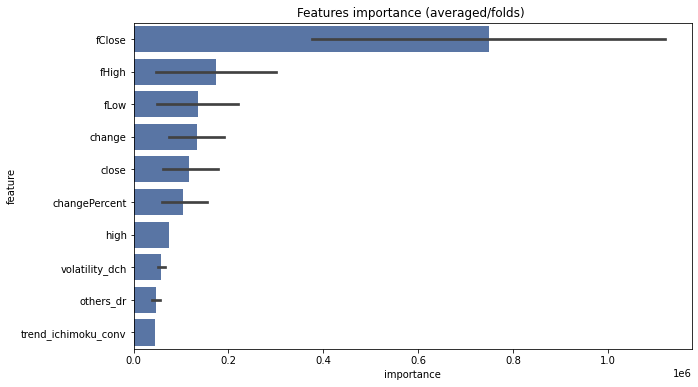

In [20]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False).index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False)[:30], color="#4c72b0")
plt.title('Features importance (averaged/folds) ')

We noticed that important features were closing price, highest price, and lowest price. This may be obvious because we are just predicting the one-day ahead closing price. If we know the closing price, we pretty much know the closing price of tomorrow.

## 5-day ahead prediction

In [21]:
train_X = pickle.load(open(f"./models/saved/tree_train_X.pkl", "rb"))
train_y = pickle.load(open(f"./models/saved/tree_train_y_5day.pkl", "rb"))

In [24]:
feature_importance_df = output_lgb_model(train_X, train_y)

train_X:  (12538, 116)
train_y:  (12538,)

 fold 0
train_idx:  2510
val_idx:  2507

MAE:  9.226826538167717
MSE:  5443.495057800934 

Target - median(target):  48.1664489030714
Target - mean(target):  50.188583693301354 

1.68% of the predictions were 1% away from actual price
3.19% of the predictions were 2% away from actual price
4.87% of the predictions were 3% away from actual price



 fold 1
train_idx:  5017
val_idx:  2507

MAE:  4.663635212465788
MSE:  9332.898350292271 

Target - median(target):  58.88943422417231
Target - mean(target):  60.18323133245265 

1.79% of the predictions were 1% away from actual price
3.59% of the predictions were 2% away from actual price
4.87% of the predictions were 3% away from actual price



 fold 2
train_idx:  7524
val_idx:  2507

MAE:  13.580866396634816
MSE:  17483.73729346546 

Target - median(target):  83.85446557638612
Target - mean(target):  86.18074139743388 

2.39% of the predictions were 1% away from actual price
4.07% of the predicti

Text(0.5, 1.0, 'Features importance (averaged/folds) ')

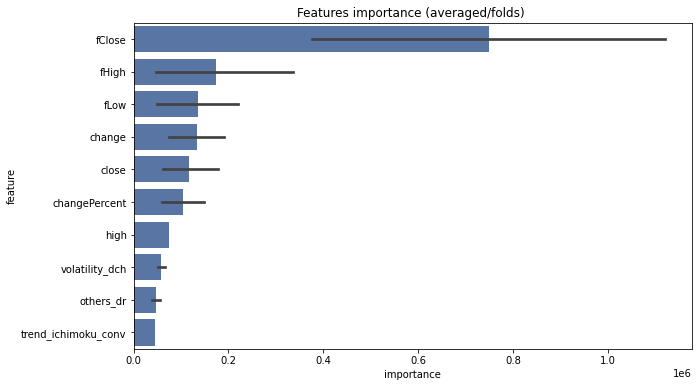

In [25]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False).index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(10,6))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False)[:30], color="#4c72b0")
plt.title('Features importance (averaged/folds) ')

We don't see much difference in feature importance between 1-day ahead prediction and 5-day ahead prediction.

# Model comparison

1. We see that Lightgbm has increasing MAE and MSE while LSTM models don't. This could be because target is normalized in LSTM models so that they can deal with COVID-19 shock more. Around last split of time series, we notice that the error of LightGBM increases a lot implying that COVID-19 affected stock market largely although LSTM model is not affected because of normalization.

2. Compared to LSTM models, LightGBM models have higher MAE and MSE. This may be because while the LSTM model is created for each company, LightGBM is created for all companies. It is true that the tree model can still split the result by the feature (ticker=company); however, it might have suddenly affected the result regardless. Since we decided to make a target to be the actual price, but not change in price to compare with LSTM models, this lost the stability of the target because each company has a different price range. If we make the target to be “change in price”, all the companies should have almost the same price range which should increase model stability.